# ニューラルネットワーク入門

## 目次

- k-最近傍法
- ロジスティック回帰
- 決定木
- ランダムフォレスト
- 勾配ブースティング
- 非線形サポートベクターマシン
- ハイパーパラメータチューニングチートシート

## Section4 最適化手法と活性化関数と損失関数

In [1]:
# 図表が使えるようにする

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import Axes3D

### 4.1 最適化手法

In [ ]:
class _target():
    test_type: int = 3
    x: float = 0
    grad: float = 0

    def __post_init__(self, *args, **kwds):
        if self.test_type == 1:
            self.params = np.array([1e-4, 4.])
            self.exact = np.array([5., 0.])
            self.elevation = 1.
            self.view_init = (35,)
            self.epoch = 2**7
            self.seed = 0
        elif self.test_type == 2:
            self.params = np.array([-1., 2.])
            self.exact = np.array([0., 0.])
            self.elevation = 0.25
            self.view_init = (75,)
            self.epoch = 2**7
            self.seed = 0
        elif self.test_type == 3:
            self.params = np.array([-3., 4.])
            self.exact = np.array([0., 0.])
            self.elevation = 0.125
            self.view_init = (55,)
            self.epoch = 2**10
            self.seed = 543
        elif self.test_type == 4:
            self.params = np.array([-2., 2.])
            self.exact = np.array([0., 0.])
            self.elevation = 0.25
            self.view_init = (45, -87)
            self.epoch = 2**8
            self.seed = 3

    def forward(self, *args, **kwds):
        if self.test_type == 1:
            return self.params[1]**2 - self.params[0]**2
        elif self.test_type == 2:
            return np.tanh(self.params[0])**2 + np.tanh(self.params[1])**2
        elif self.test_type == 3:
            return (-(np.sinc(self.params[0])+np.sinc(self.params[1]))
                    + (self.params[0]**2 + self.params[1]**2)/10)
        elif self.test_type == 4:
            return (0.125*(self.params[0]**2 + self.params[1]**2)
                    + np.tanh(self.params[0]*10)**2)

    def backward(self, *args, **kwds):
        if self.test_type == 1:
            dw = -2*self.params[0]
            db = 2*self.params[1]
        elif self.test_type == 2:
            dw = 2 * np.tanh(self.params[0]) / np.cosh(self.params[0])**2
            db = 2 * np.tanh(self.params[1]) / np.cosh(self.params[1])**2
        elif self.test_type == 3:
            dw = (np.sin(np.pi*self.params[0])/(np.pi * self.params[0]**2)
                  + 2*self.params[0]/10
                  - np.cos(np.pi*self.params[0])/self.params[0])
            db = (np.sin(np.pi*self.params[1])/(np.pi * self.params[1]**2)
                  + 2*self.params[1]/10
                  - np.cos(np.pi*self.params[1])/self.params[1])
        elif self.test_type == 4:
            dw = (0.25*self.params[0]
                  + 20 * np.tanh(self.params[0]*10)
                       / np.cosh(self.params[0]*10)**2)
            db = 0.25*self.params[1]
        return np.array([dw, db])

    def get_exact(self, *args, **kwds):
        params = self.params.copy()
        self.params = self.exact
        exact_z = self.forward()
        self.params = params
        return exact_z

class TrajectoryAnimation3D(anim.FuncAnimation):
    def __init__(self, paths, labels=[], fig=None, ax=None,
                 blit=True, coloring=None, **kwargs):
        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        self.paths = paths

        frames = paths.shape[0]

        self.lines = []
        self.points = []
        for j, opt in enumerate(labels):
            line, = ax.plot([], [], [], label=opt, lw=2, color=coloring[j])
            point, = ax.plot([], [], [], marker="o", color=coloring[j])
            self.lines.append(line)
            self.points.append(point)

        super().__init__(fig, self.animate,
                         frames=frames, blit=blit, **kwargs)

    def animate(self, i):
        start = 0 if i-8 < 0 else i-8
        j = 0
        for line, point in zip(self.lines, self.points):
            line.set_data(self.paths[start:i+1, j, 0],
                          self.paths[start:i+1, j, 1])
            line.set_3d_properties(self.paths[start:i+1, j, 2])
            line.set_zorder(i+100)
            point.set_data(self.paths[i, j, 0], self.paths[i, j, 1])
            point.set_3d_properties(self.paths[i, j, 2])
            point.set_zorder(i+101)
            j += 1
        return self.lines + self.points
    
def optPlot():
    objective = _target(test_type=4)
    start_x, start_y = objective.params
    start_z = objective.forward()

    x_range = np.arange(-5, 5, 1e-2)
    y_range = np.arange(-5, 5, 1e-2)
    X, Y = np.meshgrid(x_range, y_range)
    objective.params = np.array([X, Y])
    Z = objective.forward()
    elevation = np.arange(np.min(Z), np.max(Z), objective.elevation)

    exact_z = objective.get_exact()

    epoch = objective.epoch
    frames = 2**6
    fps = 10

    np.random.seed(seed=objective.seed)

最適化手法のパラメータの更新式
$${w_{t+1} = w_t - \eta \nabla_{w_t} \mathcal{L}(w_t)}$$

$w_t \cdots$ 時刻$t$でのパラメータ

$\eta \cdots$学習率

$\mathcal{L}(w_t) \cdots$ 損失関数

#### 4.1.1 確率的勾配降下法 (SGD)

※SGD (Stochastic Gradient Descent)

$${\begin{align*}
  g_t &= \nabla_{w_t}\mathcal{L}(w_t) \\
  \Delta w_t &= - \eta g_t \\
  w_{t+1} &= w_t + \Delta w_t
\end{align*}
}$$

#### 4.1.2 Adagrad

$${\begin{align*}
  g_t &= \nabla_{w_t} \mathcal{L}(w_t) \\
  \Delta w_t &= - \cfrac{\eta}{\displaystyle\sqrt{\sum_{\tau=1}^{t}{g_{\tau}^2}}} g_t \\
  w_{t+1} &= w_t + \Delta w_t
\end{align*}
}$$

#### 4.1.4 RMSProp

#### 4.1.4 Adam
過去の勾配の移動平均と過去の勾配の二乗平均を組み合わせた

### 4.2 活性化関数

In [30]:
import numpy as np

class Activation():
    def __init__(self, *args, **kwds):
        pass

    def forward(self, *args, **kwds):
        raise NotImplemented

    def backward(self, *args, **kwds):
        raise NotImplemented

    def update(self, *args, **kwds):
        raise NotImplemented
    
def plotActGraph(x, cls, *args, **kwds):
    activator = cls(*args, **kwds)
    
    y = activator.forward(x, *args, **kwds)
    dx = activator.backward(x, y, *args, **kwds)
    fig, ax = plt.subplots(1)
    ax.plot(x[0], y[0], label='forward')
    ax.plot(x[0], dx[0], label='backward')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()
    ax.legend(loc='best')
    
x = np.arange(-5, 5, 5e-2).reshape(1, -1)

#### 4.2.1 Sigmoid関数

順伝搬
$${y = \cfrac{1}{1 + e^{-x}}}$$

逆伝搬
$${\cfrac{\partial y}{\partial x} = y(1 - y)}$$


😇 逆伝搬の計算が簡単

👿 微分の最大値が$0.25$なので層を重ねると**勾配消失**が発生しやすい

👿 順伝搬の計算負荷が低くない

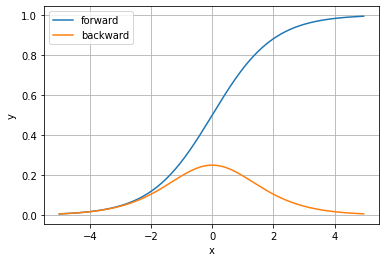

In [31]:
class Sigmoid(Activation):
    def forward(self, x, *args, **kwds):
        return 1/(1 + np.exp(-x))

    def backward(self, x, y, *args, **kwds):
        return y*(1 - y)

plotActGraph(x, Sigmoid)

#### 4.2.2 tanh関数

順伝搬
$${y = \tanh x = \cfrac{e^x - e^{-x}}{e^x + e^{-x}}}$$

逆伝搬
$${\cfrac{\partial y}{\partial x} = \textrm{sech}^2 x = \cfrac{1}{\cosh^2 x} = \cfrac{4}{(e^x + e^{-x})^2}}$$

😇 Sigmoidに比べて勾配損失のリスク軽減

👿 極端に大きい・小さい入力の微分が$0$になる

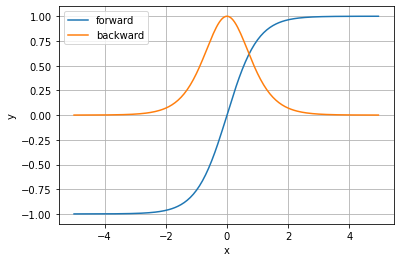

In [32]:
class Tanh(Activation):
    def forward(self, x, *args, **kwds):
        return np.tanh(x)

    def backward(self, x, *args, **kwds):
        return 1 - np.tanh(x)**2

plotActGraph(x, Tanh)

#### 4.2.3 ReLU関数

順伝搬
$${y = \left\{
  \begin{array}{cc}
    x & (x \gt 0) \\
    0 & (x \le 0)
  \end{array}
\right.
}$$

逆伝搬
$${\cfrac{\partial y}{\partial x} = \left\{
  \begin{array}{cc}
    1 & (x \gt 0) \\
    0 & (x \le 0)
  \end{array}
\right.
}$$

😇 勾配損失が起こりにくい（多層化しやすい）

👿 負の入力に対しては一切学習が進まない

※ 誤差逆伝搬法において活性化関数は微分可能であるべきですが、実際のところピッタリ$x=0$となる場合の方が少ない&どうせ$0$なので問題になっていません。


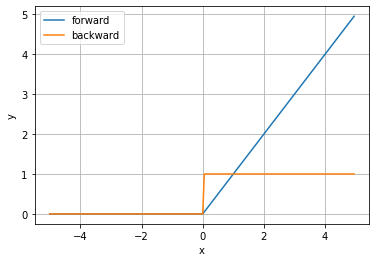

In [33]:
class ReLU(Activation):
    def forward(self, x, *args, **kwds):
        return np.maximum(0, x)

    def backward(self, x, *args, **kwds):
        return np.where(x > 0, 1, 0)

plotActGraph(x, ReLU)

#### 4.2.4 Softmax関数

順伝搬
$${y_i = \cfrac{e^{x_i}}{\displaystyle\sum_{k=1}^{n}{e^{x_k}}} \quad (i = 1, 2, \ldots, n)}$$

逆伝搬
$$\left( \cfrac{\partial y}{\partial x} \right)_i=\sum_{j=1}^{n}\begin{cases}y_i(1-y_j) && (i = j)\\  -y_i y_j && (i \ne j)\end{cases}$$

😇 出力値の合計が1になる（出力がそのまま確率として利用できる）

※出力値の合計が1になるため、主に多クラス分類の出力層として利用されます。また、データが2個の場合はSigmoid関数になります。

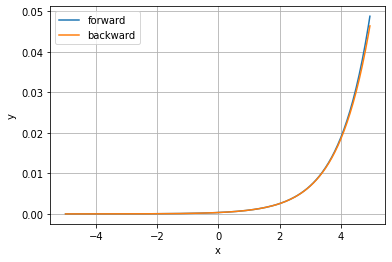

In [34]:
class Softmax(Activation):
    def forward(self, x, *args, **kwds):
        exp_x = np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)

    def backward(self, x, y, *args, **kwds):
        return y*(1 - y)
    
plotActGraph(x, Softmax)

#### 4.2.5 Swish関数

順伝搬
$${y = x \sigma_{sigmoid}(\beta x) = \cfrac{x}{1 + e^{-\beta x}}}$$

逆伝搬
$${\cfrac{\partial y}{\partial x} = \beta y + \sigma_{sigmoid}(\beta x)(1 - \beta y) = \beta y + \cfrac{1 - \beta y}{1 + e^{-\beta x}}}$$

😇 微分可能（無限回微分可能）

😇 負の入力に対して負の値を取れる

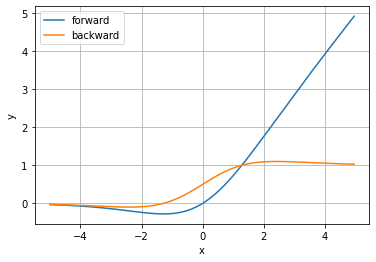

In [36]:
class Swish(Activation):
    def __init__(self, beta=1, *args, **kwds):
        self.beta = beta
        super().__init__(*args, **kwds)

    def forward(self, x, *args, **kwds):
        return x/(1 + np.exp(-self.beta*x))


    def backward(self, x, y, *args, **kwds):
        return self.beta*y + (1 - self.beta*y)/(1 + np.exp(-self.beta*x))
    
plotActGraph(x, Swish)

#### 4.2.6 Mish関数

順伝搬
$${y = x \tanh{(\varsigma(x))} = x \tanh{(\ln{(1 + e^x)})}}$$

逆伝搬
$$\cfrac{\partial y}{\partial x} = \cfrac{e^x \omega}{\delta^2}$$
$${\begin{align*}
    \omega &= 4(x + 1) + 4e^{2x} + e^{3x} + (4x + 6)e^x 
    ,&\delta &= 2e^x + e^{2x} + 2
\end{align*}}$$

😇 すごい性能いいらしい

👿 計算負荷が高い

👿 逆伝搬の式が複雑怪奇

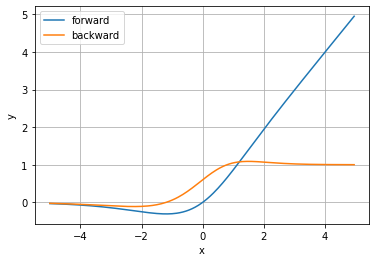

In [35]:
class Mish(Activation):
    def forward(self, x, *args, **kwds):
        return x*np.tanh(np.logaddexp(x, 0))

    def backward(self, x, *args, **kwds):
        omega = (4*(x + 1) + 4*np.exp(2*x)
              + np.exp(3*x) + (4*x + 6)*np.exp(x))
        delta = 2*np.exp(x) + np.exp(2*x) + 2
        return np.exp(x)*omega/delta**2

plotActGraph(x, Mish)

### 4.3 損失関数

In [28]:
class Error():
    def __init__(self, *args, **kwds):
        self.error = 0

    def forward(self, *args, **kwds):
        pass

    def backward(self, *args, **kwds):
        pass

    def total_error(self, *args, **kwds):
        return np.sum(self.error)/self.error.size
    
def plotErrGraph(y, cls, *args, **kwds):
    activator = cls(*args, **kwds)
    
    l = activator.forward(y, 0 ,*args, **kwds)
    dl = activator.backward(y, 1, *args, **kwds)
    fig, ax = plt.subplots(1)
    ax.plot(x[0], l[0], label='t=0')
    ax.plot(x[0], dl[0], label='t=1')
    ax.set_xlabel('y')
    ax.set_ylabel('error')
    ax.grid()
    ax.legend(loc='best')
    
x = np.arange(0, 1, 5e-2).reshape(1, -1)

#### 4.3.1 平均二乗誤差 (MSE)

$${\mathcal{L}(y) = \cfrac{1}{2} (y - t)^2}$$

微分
$${\cfrac{\partial \mathcal{L}}{\partial y} = \cfrac{1}{2} \times 2(y - t) = y - t}$$

利用シーン：線形回帰問題

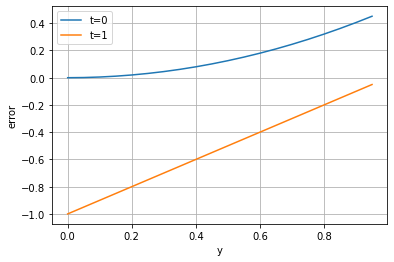

In [29]:
class SquareError(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = 0.5 * (y - t)**2
        return self.error

    def backward(self, y, t, *args, **kwds):
        return y - t
    
plotErrGraph(x, SquareError)

#### 4.3.2 2値交差エントロピー (BCE)

$${\mathcal{L}(y) = - t \log y - (1 - t) \log(1 - y)}$$

微分
$${\cfrac{\partial \mathcal{L}}{\partial y} = \cfrac{y - t}{y(1 - y)}}$$

利用シーン：2クラス分類問題（出力層の活性化関数がSigmoid関数）

/home/rei/dlc/colab/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rei/dlc/colab/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rei/dlc/colab/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


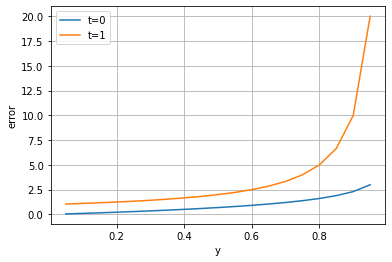

In [27]:
class BinaryCrossEntropy(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = - t*np.log(y) - (1 - t)*np.log(1 - y)
        return self.error

    def backward(self, y, t, *args, **kwds):
        return (y - t) / (y*(1 - y))
    
plotErrGraph(x, BinaryCrossEntropy)

#### 4.3.3 交差エントロピー (CE)

$${\mathcal{L}(y) = - t \log y}$$

微分
$${\cfrac{\partial \mathcal{L}}{\partial y_i} = -\cfrac{t_i}{y_i}
}$$

利用シーン：多クラス分類問題（出力層の活性化関数がSoftmax関数）

※Softmax - CE 層の逆伝搬

$${\begin{align*}
  \left( \cfrac{\partial \mathcal{L}}{\partial y} \cfrac{\partial y}{\partial x} \right)_i &= \sum_{j=1}^{n}{\left( \cfrac{\partial \mathcal{L}}{\partial y_j}\cfrac{\partial y_j}{\partial x_i} \right)} \\
  &= \sum_{j=1}^{n}{
\left\{ \begin{array}{ccc}
    -\cfrac{t_i}{y_i} \times y_i (1 - y_i) & = t_i y_i - t_i & (j=i) \\
    -\cfrac{t_j}{y_j} \times (-y_i y_j) &= t_j y_i & (j \ne i)
\end{array} \right\}
} \\
  &= (t_i y_i - t_i)_{j=i} + y_i \sum_{j=1, j\ne i}^{n}{t_j}_j \ne i \\
  &= y_i \sum_{j=1}^{n}{t_j} - t_i \\
  &= y_i - t_i 
\end{align*}
}$$

/home/rei/dlc/colab/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rei/dlc/colab/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rei/dlc/colab/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


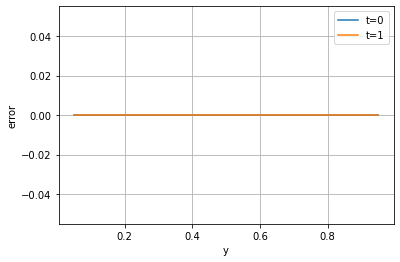

In [26]:
class CrossEntropy(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = - t*np.log(y)
        return self.error

    def backward(self, y, t, *args, **kwds):
        return - t/y

plotErrGraph(x, CrossEntropy)